# Boosting a decision stump

The goal of this notebook is to implement your own boosting module.

**Brace yourselves**! This is going to be a fun and challenging assignment.


* Use Pandas to do some feature engineering.
* Modify the decision trees to incorporate weights.
* Implement Adaboost ensembling.
* Use your implementation of Adaboost to train a boosted decision stump ensemble.
* Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
* Explore the robustness of Adaboost to overfitting.

Let's get started!

In [1]:
# Import some libs

import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Extracting the target and the feature columns

We will now repeat some of the feature processing steps that we saw in the previous assignment:

First, we re-assign the target to have +1 as a safe (good) loan, and -1 as a risky (bad) loan.

Next, we select four categorical features: 
1. grade of the loan 
2. the length of the loan term
3. the home ownership status: own, mortgage, rent
4. number of years of employment.

In [2]:
loans_df = pandas.read_csv('data/lending-club-data.csv', low_memory=False)

# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans_df['safe_loans'] = loans_df['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans_df.drop(columns=['bad_loans'])

features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'

loans_df = loans_df[features + [target]]

## Subsample dataset to make sure classes are balanced
Just as we did in the previous assignment, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `seed = 1` so everyone gets the same results.

In [3]:
safe_loans_raw = loans_df[loans_df[target] == +1]
risky_loans_raw = loans_df[loans_df[target] == -1]

# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = risky_loans_raw.shape[0]/safe_loans_raw.shape[0]

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=percentage, random_state=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

print ("Percentage of safe loans                 : {}".format(safe_loans.shape[0] / loans_data.shape[0]))
print ("Percentage of risky loans                : {}".format(risky_loans.shape[0] / loans_data.shape[0]))
print ("Total number of loans in our new dataset : {}".format(loans_data.shape[0]))

Percentage of safe loans                 : 0.5
Percentage of risky loans                : 0.5
Total number of loans in our new dataset : 46300


## Transform categorical data into binary features

In [4]:
print(loans_data.dtypes)
categorical_variables = list(loans_data.select_dtypes(include=['object']).columns)
print(categorical_variables)

one_hot_data = pandas.get_dummies(loans_data[categorical_variables], prefix=categorical_variables)
# need to add inplace in oreder to drop columns.
loans_data.drop(columns=categorical_variables, axis=1, inplace=True)
loans_data = pandas.concat([loans_data, one_hot_data], axis=1)

print(loans_data['grade_A'].values.sum())
print (loans_data.dtypes)

grade             object
term              object
home_ownership    object
emp_length        object
safe_loans         int64
dtype: object
['grade', 'term', 'home_ownership', 'emp_length']
6508
safe_loans                 int64
grade_A                    uint8
grade_B                    uint8
grade_C                    uint8
grade_D                    uint8
grade_E                    uint8
grade_F                    uint8
grade_G                    uint8
term_ 36 months            uint8
term_ 60 months            uint8
home_ownership_MORTGAGE    uint8
home_ownership_OTHER       uint8
home_ownership_OWN         uint8
home_ownership_RENT        uint8
emp_length_1 year          uint8
emp_length_10+ years       uint8
emp_length_2 years         uint8
emp_length_3 years         uint8
emp_length_4 years         uint8
emp_length_5 years         uint8
emp_length_6 years         uint8
emp_length_7 years         uint8
emp_length_8 years         uint8
emp_length_9 years         uint8
emp_length_< 1

## Train-test split

We split the data into a train test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [5]:
np.random.seed(1)

train_data, validation_data = train_test_split(loans_data, test_size=0.2)

# Weighted decision trees

Let's modify our decision tree code from Module 5 to support weighting of individual data points.

### Weighted error definition

Consider a model with $N$ data points with:
* Predictions $\hat{y}_1 ... \hat{y}_n$ 
* Target $y_1 ... y_n$ 
* Data point weights $\alpha_1 ... \alpha_n$.

Then the **weighted error** is defined by:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$
where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.


### Write a function to compute weight of mistakes

Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:
* `labels_in_node`: Targets $y_1 ... y_n$ 
* `data_weights`: Data point weights $\alpha_1 ... \alpha_n$

We are interested in computing the (total) weight of mistakes, i.e.
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$
This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$

The function **intermediate_node_weighted_mistakes** should first compute two weights: 
 * $\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y}_i = -1$ i.e $\mathrm{WM}(\mathbf{\alpha}, \mathbf{-1}$)
 * $\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y}_i = +1$ i.e $\mbox{WM}(\mathbf{\alpha}, \mathbf{+1}$)
 
 where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively.
 
After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function **intermediate_node_weighted_mistakes** should return the lower of the two weights of mistakes, along with the class associated with that weight. We have provided a skeleton for you with `YOUR CODE HERE` to be filled in several places.

In [6]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = np.sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = np.sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if weighted_mistakes_all_positive <= weighted_mistakes_all_negative:
        return (weighted_mistakes_all_positive,+1)
    else:
        return (weighted_mistakes_all_negative,-1)

**Checkpoint:** Test your **intermediate_node_weighted_mistakes** function, run the following cell:

In [7]:
example_labels = np.array([-1, -1, 1, 1, 1])
example_data_weights = np.array([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


### Function to pick best feature to split on

We continue modifying our decision tree code from the earlier assignment to incorporate weighting of individual data points. The next step is to pick the best feature to split on.

The **best_splitting_feature** function is similar to the one from the earlier assignment with two minor modifications:
  1. The function **best_splitting_feature** should now accept an extra parameter `data_weights` to take account of weights of data points.
  2. Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.
  
Complete the following function. Comments starting with `DIFFERENT HERE` mark the sections where the weighted version differs from the original implementation.

In [8]:
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = (left_weighted_mistakes+right_weighted_mistakes)/sum(data_weights)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

**Checkpoint:** Now, we have another checkpoint to make sure you are on the right track.

In [9]:
features = list(loans_data.columns)
features.remove('safe_loans')

example_data_weights = np.array(len(train_data)* [1.5])
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term_ 36 months':
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


### Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. Recall from the previous assignments that each node in the decision tree is represented as a dictionary which contains the following keys:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }
    
Let us start with a function that creates a leaf node given a set of target values:

In [10]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class ## YOUR CODE HERE
    
    return leaf 

We provide a function that learns a weighted decision tree recursively and implements 3 stopping conditions:
1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches **max_depth**. 

In [11]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print("Stopping condition 1 reached.")                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print("Stopping condition 2 reached.")                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Here is a recursive function to count the nodes in your tree:

In [12]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

Run the following test code to check your implementation. Make sure you get **'Test passed'** before proceeding.

In [13]:
example_data_weights = np.array([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print('Test passed!')
else:
    print('Test failed... try again!')
    print('Number of nodes found:', count_nodes(small_data_decision_tree))
    print('Number of nodes that should be there: 7') 

--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature term_ 36 months. (9419, 27621)
--------------------------------------------------------------------
Subtree, depth = 2 (9419 data points).
Split on feature grade_A. (9293, 126)
--------------------------------------------------------------------
Subtree, depth = 3 (9293 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (126 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (27621 data points).
Split on feature grade_D. (22974, 4647)
--------------------------------------------------------------------
Subtree, depth = 3 (22974 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4647 data po

Let us take a quick look at what the trained tree is like. You should get something that looks like the following

```
{'is_leaf': False,
    'left': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'splitting_feature': 'grade_A'
     },
    'prediction': None,
    'right': {'is_leaf': False,
        'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
        'prediction': None,
        'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
        'splitting_feature': 'grade_D'
     },
     'splitting_feature': 'term. 36 months'
}```

In [14]:
small_data_decision_tree

{'is_leaf': False,
 'prediction': None,
 'splitting_feature': 'term_ 36 months',
 'left': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_A',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1}},
 'right': {'is_leaf': False,
  'prediction': None,
  'splitting_feature': 'grade_D',
  'left': {'splitting_feature': None, 'is_leaf': True, 'prediction': 1},
  'right': {'splitting_feature': None, 'is_leaf': True, 'prediction': -1}}}

### Making predictions with a weighted decision tree

We give you a function that classifies one data point. It can also return the probability if you want to play around with that as well.

In [15]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree

Now, we will write a function to evaluate a decision tree by computing the classification error of the tree on the given dataset.

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

The function called **evaluate_classification_error** takes in as input:
1. `tree` (as described above)
2. `data` (an SFrame)

The function does not change because of adding data point weights.

In [16]:
def evaluate_classification_error(tree, data, target):
    # Apply the classify(tree, x) to each row in your data
    prediction = []
    for i, row in data.iterrows():
        prediction.append(classify(tree, row))
    
    # Once you've made the predictions, calculate the classification error and return it
    ## YOUR CODE HERE
    return sum(data[target]!=prediction)/len(data)

In [17]:
evaluate_classification_error(small_data_decision_tree, validation_data, target)

0.4037796976241901

### Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

Let us fit a weighted decision tree with `max_depth = 2`.

In [18]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(train_data.shape[0] - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature emp_length_3 years. (33976, 3064)
--------------------------------------------------------------------
Subtree, depth = 2 (33976 data points).
Split on feature emp_length_8 years. (32350, 1626)
--------------------------------------------------------------------
Subtree, depth = 3 (32350 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (1626 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (3064 data points).
Stopping condition 1 reached.


Now, we will compute the classification error on the `subset_20`, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [19]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20, target)

0.2

Now, let us compare the classification error of the model `small_data_decision_tree_subset_20` on the entire test set `train_data`:

In [20]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data, target)

0.4996490280777538

The model `small_data_decision_tree_subset_20` performs **a lot** better on `subset_20` than on `train_data`.

So, what does this mean?
* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
* The points with zero weights are basically ignored during training.

**Quiz Question**: Will you get the same model as `small_data_decision_tree_subset_20` if you trained a decision tree with only the 20 data points with non-zero weights from the set of points in `subset_20`?
<br>
**Your answer**: Yes

# Implementing your own Adaboost (on decision stumps)

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with **decision tree stumps** by training trees with **`max_depth=1`**.

Recall from the lecture the procedure for Adaboost:

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$
  
Complete the skeleton for the following code to implement **adaboost_with_tree_stumps**. Fill in the places with `YOUR CODE HERE`.

In [21]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.array([1.]*data.shape[0])
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print('=====================================================')
        print('Adaboost Iteration %d' % t)
        print('=====================================================')        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = []
        for i, row in data.iterrows():
            predictions.append(classify(tree_stump, row))
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_corrects = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # YOUR CODE HERE
        weighted_error = np.sum(is_wrong*alpha)/np.sum(alpha)
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        weight = (1/2)*np.log((1-weighted_error)/weighted_error)
        weights.append(weight)

        # Adjust weights on data point
#         adjustment = []
#         for i_c in is_corrects:
#             adjustment.append(np.exp(-weight) if i_c == True else np.exp(weight))
        adjustment = [np.exp(-weight) if i_c==True else np.exp(weight) for i_c in is_corrects]
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights
        ## YOUR CODE HERE 
        alpha = alpha*np.array(adjustment)
        alpha = alpha/np.sum(alpha)
    
    return weights, tree_stumps

### Checking your Adaboost code

Train an ensemble of **two** tree stumps and see which features those stumps split on. We will run the algorithm with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 2`

In [22]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature term_ 36 months. (9419, 27621)
--------------------------------------------------------------------
Subtree, depth = 2 (9419 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (27621 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade_A. (31864, 5176)
--------------------------------------------------------------------
Subtree, depth = 2 (31864 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5176 data points).
Reached maximum depth. Stopping for now.


In [23]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print("(leaf, label: %s)" % tree['prediction'])
        return None
    split_feature, split_value = split_name.split('_')
    print('                       root')
    print('         |---------------|----------------|')
    print('         |                                |')
    print('         |                                |')
    print('         |                                |')
    print('  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name))))
    print('         |                                |')
    print('         |                                |')
    print('         |                                |')
    print('    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

Here is what the first stump looks like:

In [24]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term_ 36 months == 0]            [term_ 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


Here is what the next stump looks like:

In [25]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_A == 0]                    [grade_A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [26]:
print (stump_weights)

[0.15102996067142907, 0.18680481912767996]


If your Adaboost is correctly implemented, the following things should be true:

* `tree_stumps[0]` should split on **term_ 36 months** with the prediction -1 on the left and +1 on the right.
* `tree_stumps[1]` should split on **grade_A** with the prediction -1 on the left and +1 on the right.
* Weights should be approximately `[0.151, 0.187]` 

**Reminders**
- Stump weights ($\mathbf{\hat{w}}$) and data point weights ($\mathbf{\alpha}$) are two different concepts.
- Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.
- Data point weights ($\mathbf{\alpha}$) tell you how important each data point is while training a decision stump.

### Training a boosted ensemble of 10 stumps

Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the **adaboost_with_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [27]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature term_ 36 months. (9419, 27621)
--------------------------------------------------------------------
Subtree, depth = 2 (9419 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (27621 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37040 data points).
Split on feature grade_A. (31864, 5176)
--------------------------------------------------------------------
Subtree, depth = 2 (31864 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5176 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

## Making predictions

Recall from the lecture that in order to make predictions, we use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

We need to do the following things:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

Complete the following skeleton for making predictions:

In [28]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*data.shape[0])
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = []
        for _, row in data.iterrows():
            predictions.append(classify(tree_stump, row))
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        scores = scores + stump_weights[i] * np.array(predictions)
    
#     res = []
#     for score in scores:
#         res.append(+1 if score > 0 else -1)
        
    return np.array([+1 if score > 0 else -1 for score in scores])

In [29]:
predictions = predict_adaboost(stump_weights, tree_stumps, validation_data)
accuracy = np.sum(predictions == validation_data[target].values) / len(predictions)
print('Accuracy of 10-component ensemble = %s' % accuracy) 

Accuracy of 10-component ensemble = 0.6178185745140389


Now, let us take a quick look what the `stump_weights` look like at the end of each iteration of the 10-stump ensemble:

In [30]:
stump_weights

[0.15102996067142907,
 0.18680481912767996,
 0.09492433404241442,
 0.0661748989444985,
 0.06505486958615858,
 0.055146253227014316,
 0.05815259709705533,
 0.04583356865830019,
 0.030453693301857435,
 0.020257874892019107]

<function matplotlib.pyplot.show(*args, **kw)>

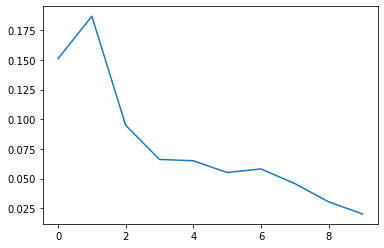

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(stump_weights)
plt.show

**Quiz Question:** Are the weights monotonically decreasing, monotonically increasing, or neither?
<br>
**Your answer:** neighter
<br>
**Reminder**: Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.

**Quiz Question:** What is the accuracy?
<br>
**Your answer:** 0.63
<br>